<a href="https://colab.research.google.com/github/edermartelinho/Deep_Learning/blob/main/Regres%C3%A3o_Logistica__X_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline
np.random.seed(1)


### Definindo algumas funções úteis

In [2]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

### Definindo outras funções para testar a integridade das implementações

In [3]:
def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3)
    Y_assess = np.random.randn(2, 3)
    return X_assess, Y_assess

def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y


def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    b1 = np.random.randn(4,1)
    b2 = np.array([[ -1.3]])

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': b1,
     'b2': b2}

    return X_assess, parameters

def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = (np.random.randn(1, 3) > 0)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    a2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]))

    return a2, Y_assess, parameters

def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    cache = {'A1': np.array([[-0.00616578,  0.0020626 ,  0.00349619],
         [-0.05225116,  0.02725659, -0.02646251],
         [-0.02009721,  0.0036869 ,  0.02883756],
         [ 0.02152675, -0.01385234,  0.02599885]]),
  'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]),
  'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
         [-0.05229879,  0.02726335, -0.02646869],
         [-0.02009991,  0.00368692,  0.02884556],
         [ 0.02153007, -0.01385322,  0.02600471]]),
  'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]])}
    return parameters, cache, X_assess, Y_assess

def update_parameters_test_case():
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
 'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
 'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
 'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
 'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
 'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
 'db2': np.array([[ -1.08923140e-05]])}
    return parameters, grads

def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    return X_assess, Y_assess

def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    return parameters, X_assess

### Carregando o *Dataset*

### Visualizando o *dataset*

In [4]:
X, Y = load_planar_dataset()

In [ ]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

### Verificando a dimensão do *dataset*

In [ ]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

### Usando a regressão logística como classificador

In [7]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Plotando a fronteira de decisão do modelo

In [ ]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")
# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions)
+ np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
'% ' + "(percentage of correctly labelled datapoints)")

# Modelo de rede neural

### Definindo a arquitetura do MLP

In [9]:
def layer_sizes(X, Y):

  n_x = X.shape[0] # size of input layer
  n_h = 4 # size of hidden layer
  n_y = Y.shape[0] # size of output layer

  return (n_x, n_h, n_y)

### Verificando os valores

In [ ]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

### Inicializando os parâmetros do modelo

In [11]:
def initialize_parameters(n_x, n_h, n_y):

  np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.

  W1 = np.random.randn(n_h,n_x) * 0.01
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_y,n_h) * 0.01
  b2 = np.zeros((n_y,1))

  assert (W1.shape == (n_h, n_x))
  assert (b1.shape == (n_h, 1))
  assert (W2.shape == (n_y, n_h))
  assert (b2.shape == (n_y, 1))
  parameters = {"W1": W1,
  "b1": b1,
  "W2": W2,
  "b2": b2}
  return parameters

### Verificando a integridade do código

In [ ]:
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

### Implementando a propagação *forward*

In [13]:
def forward_propagation(X, parameters):

# Retrieve each parameter from the dictionary "parameters"

  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]

# Implement Forward Propagation to calculate A2 (probabilities)

  Z1 = np.dot(W1,X)+b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2,A1)+b2
  A2 = sigmoid(Z2)

  assert(A2.shape == (1, X.shape[1]))
  cache = {"Z1": Z1,
  "A1": A1,
  "Z2": Z2,
  "A2": A2}
  return A2, cache


### Verificando a integridade do código

In [ ]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
# Note: we use the mean here just to make sure that your output matches ours.
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

### Calculando o Custo

In [15]:
def compute_cost(A2, Y, parameters):

  m = Y.shape[1] # number of example
  # Compute the cross-entropy cost

  logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),(1-Y))
  cost = - 1/m*np.sum(logprobs)

  cost = float(np.squeeze(cost)) # makes sure cost is the dimension we expect.
  # E.g., turns [[17]] into 17
  assert(isinstance(cost, float))
  return cost

### Verificando a integridade do código

In [ ]:
A2, Y_assess, parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

### Implementando a propagação *backward*

In [17]:
def backward_propagation(parameters, cache, X, Y):

  m = X.shape[1]

  # First, retrieve W1 and W2 from the dictionary "parameters".
  W1 = parameters["W1"]
  W2 = parameters["W2"]

# Retrieve also A1 and A2 from dictionary "cache".
  A1 = cache["A1"]
  A2 = cache["A2"]

# Backward propagation: calculate dW1, db1, dW2, db2.
  dZ2 = A2-Y
  dW2 = (1/m)*np.dot(dZ2,A1.T)
  db2 = (1/m)*np.sum(dZ2,axis=1,keepdims=True)
  dZ1 = np.dot(W2.T,dZ2)*(1-(A1)**2)
  dW1 = (1/m)*np.dot(dZ1,X.T)
  db1 = (1/m)*np.sum(dZ1,axis=1,keepdims=True)

  grads = {"dW1": dW1,
          "db1": db1,
          "dW2": dW2,
          "db2": db2}
  return grads

### Verificando a integridade do código

In [ ]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()
grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

### Atualização dos parâmetros

In [19]:
def update_parameters(parameters, grads, learning_rate = 1.2):

  # Retrieve each parameter from the dictionary "parameters"
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]

  # Retrieve each gradient from the dictionary "grads"
  dW1 = grads["dW1"]
  db1 = grads["db1"]
  dW2 = grads["dW2"]
  db2 = grads["db2"]

  # Update rule for each parameter
  W1 = W1-learning_rate*dW1
  b1 = b1-learning_rate*db1
  W2 = W2-learning_rate*dW2
  b2 = b2-learning_rate*db2

  parameters = {"W1": W1,
  "b1": b1,
  "W2": W2,
  "b2": b2}
  return parameters

### Verificando a integridade do código

In [ ]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

### Implementando o modelo da RNA

In [21]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):

  np.random.seed(3)
  n_x = layer_sizes(X, Y)[0]
  n_y = layer_sizes(X, Y)[2]

  # Initialize parameters
  parameters = initialize_parameters(n_x, n_h, n_y)

  # Loop (gradient descent)
  for i in range(0, num_iterations):

      # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
      A2, cache = forward_propagation(X, parameters)

      # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
      cost = compute_cost(A2, Y, parameters)

      # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
      grads = backward_propagation(parameters, cache, X, Y)

      # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
      parameters = update_parameters(parameters, grads, learning_rate = 1.2)

      # Print the cost every 1000 iterations
      if print_cost and i % 1000 == 0:
          print ("Cost after iteration %i: %f" %(i, cost))
  return parameters

### Verificando a integridade do código

In [ ]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

### Calculando predições

In [23]:
def predict(parameters, X):

  # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
  A2, cache = forward_propagation(X, parameters)
  predictions = (A2 > 0.5)

  return predictions

### Verificando a integridade do código

In [ ]:
parameters, X_assess = predict_test_case()
predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

### Aplicando o modelo no *dataset* sob estudo

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219506
Cost after iteration 9000: 0.218571


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

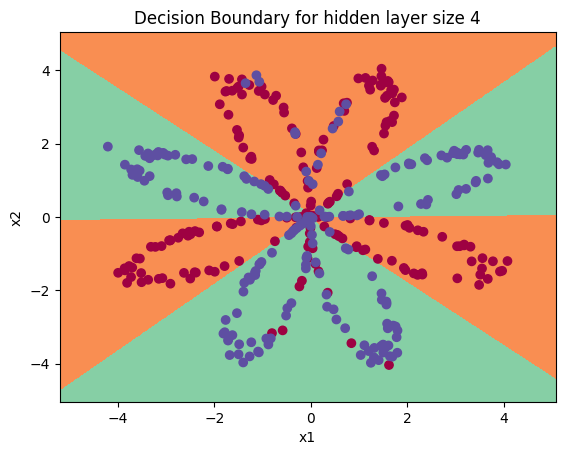

In [25]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

### Calculando a acurácia

In [26]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


<ipython-input-26-d1694606b71e>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')


### Sintonizando o tamanho da camada intermediária

<ipython-input-27-363b8c806bab>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.75 %


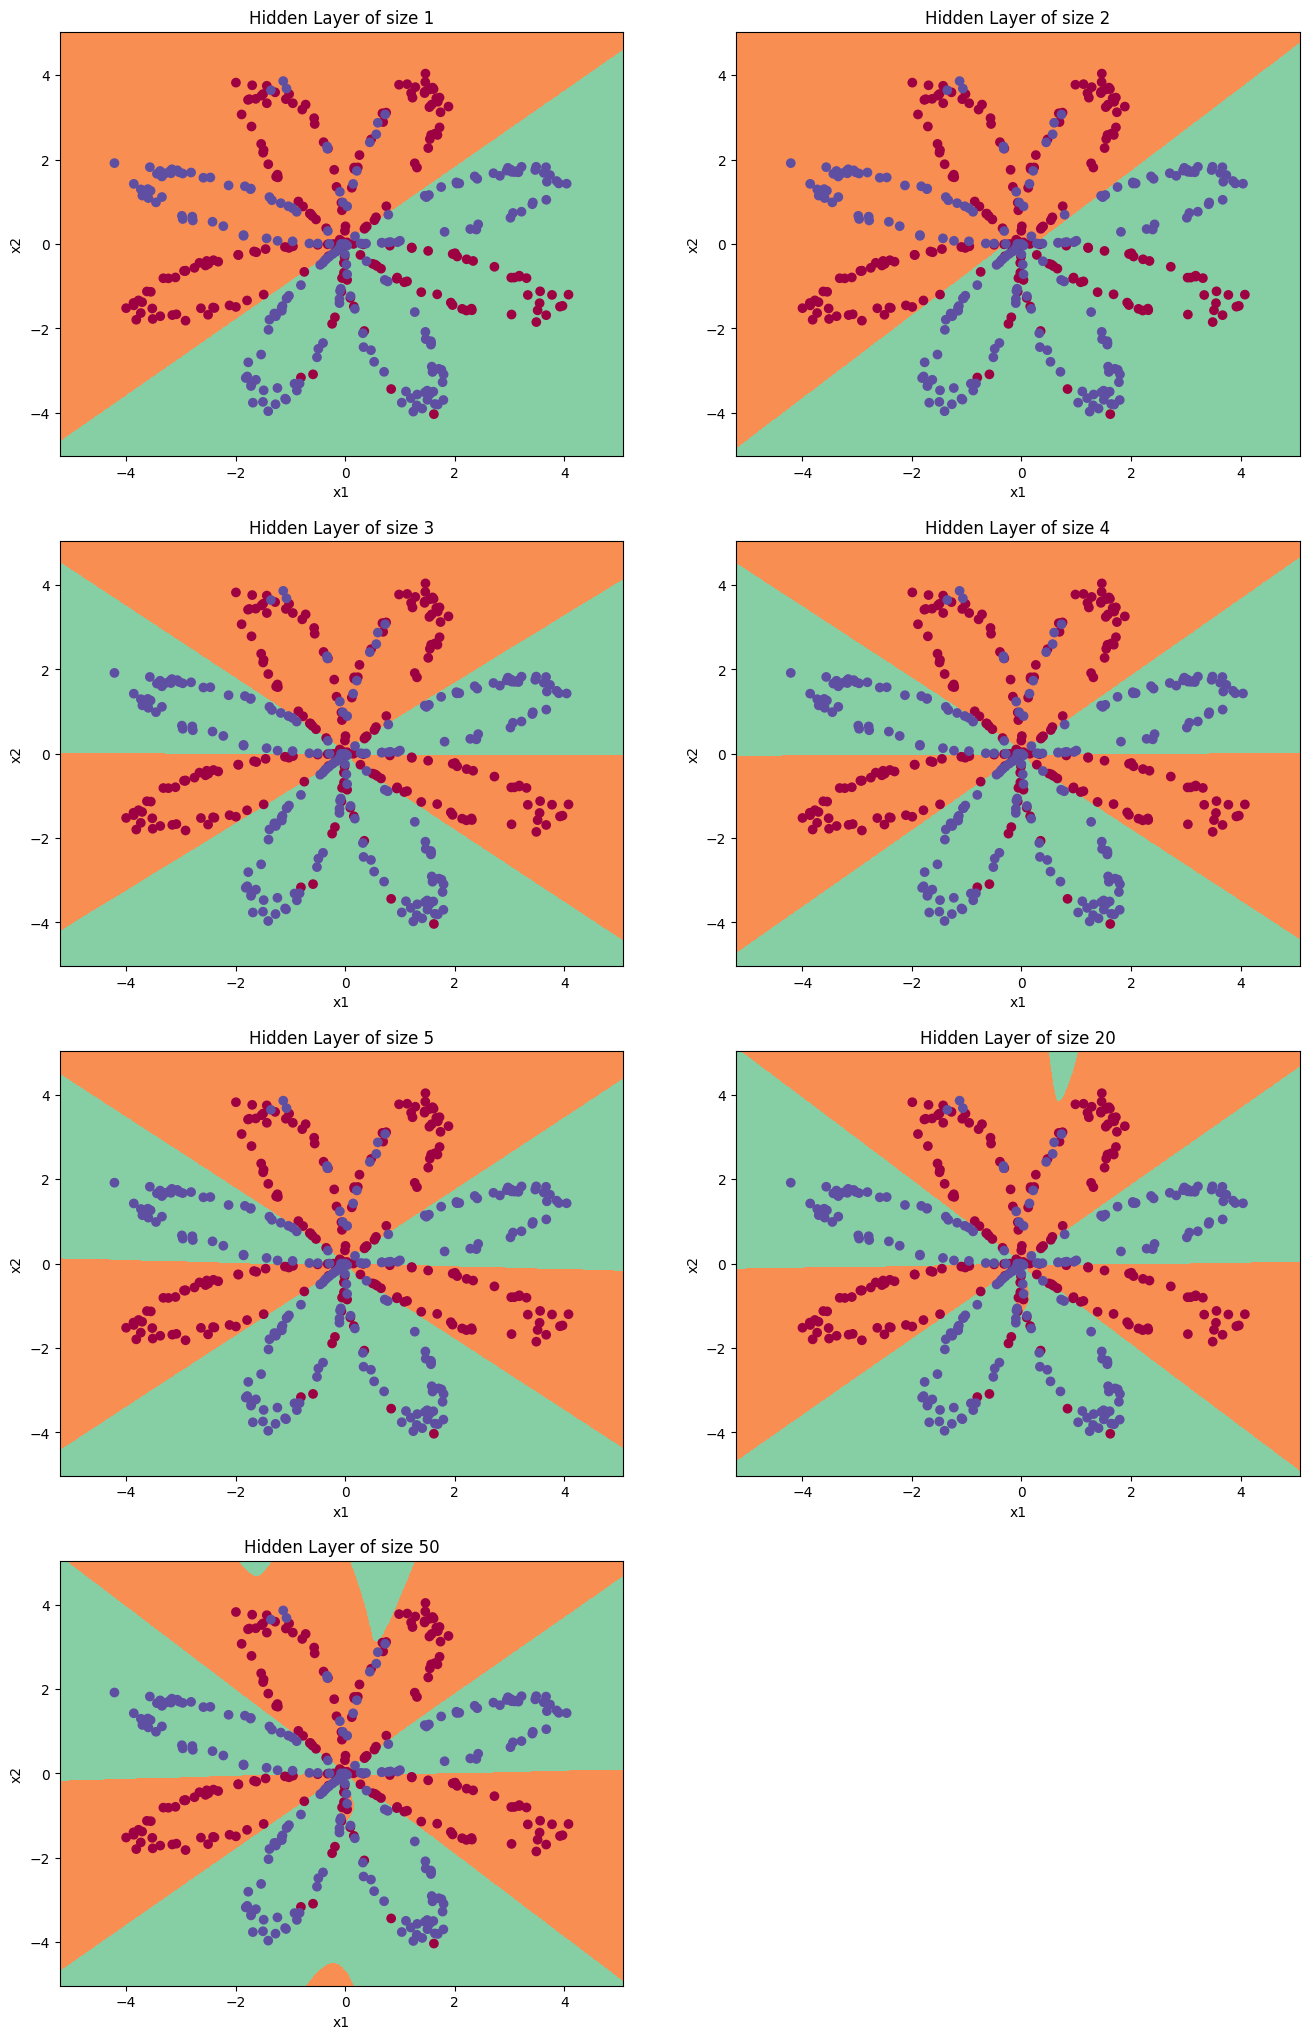

In [27]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))